This Jupyter NoteBook contain 3 sections:

Section 1: Initial Code
This section includes the initial python code that i started with.

Section 2: Code Modification
This section includes a the changes made on the code and the reasoning behind it.

Section 3 : Final Result
This section provides the final code retained for this function.

**SECTION 1: INITIAL CODE**

I chose to start from scratch with simple code generated by prompts to some of the most widely used AI code generators. This approach provided me a valuable opportunity to put into practice the concepts I’ve recently learned and directly challenge my understanding of the material in real life scenario. Beginning with a simple straightforward baseline from the function description, and some researchs on similar scenarios, allowed me to build confidence and iteratively refine the solution, ensuring a deep grasp of the underlying problem and methods before moving on to more sophisticated techniques.
This approach is used for all the functions in this Capstone Competition and provided good results for the majority of the functions.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     3.631
Date:                Mon, 09 Jun 2025   Prob (F-statistic):             0.0216
Time:                        18:19:08   Log-Likelihood:                 52.730
No. Observations:                  41   AIC:                            -97.46
Df Residuals:                      37   BIC:                            -90.61
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0746      0.037     -2.038      0.0

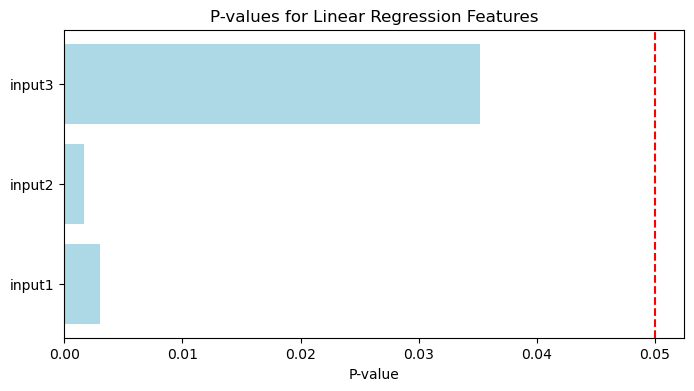

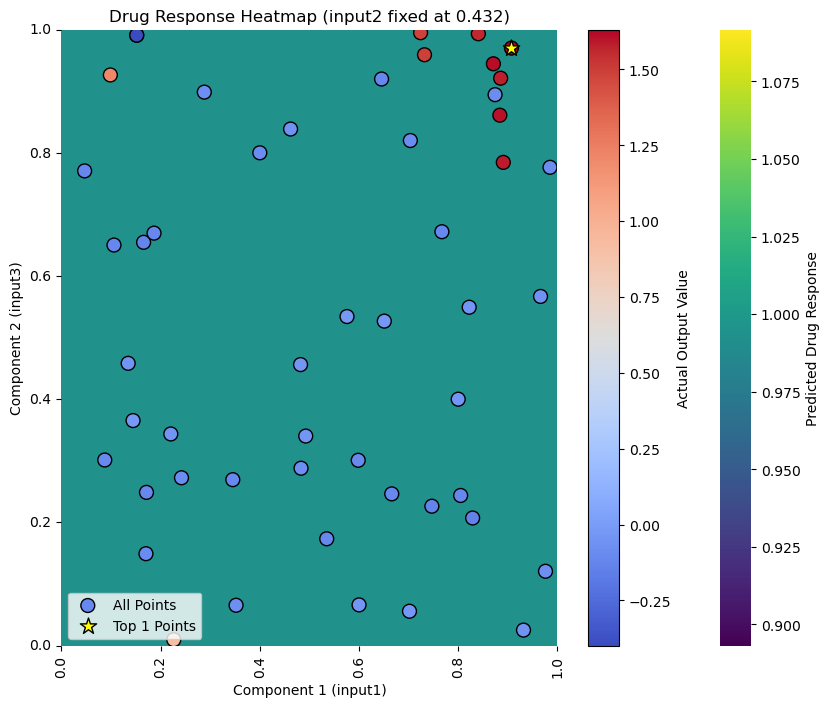

Best Formulation: [input1 = 0.907380, input2 = 0.054583, input3 = 0.969967]
Best Response: 1.631309


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF , ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns

###############################

# this piece of code was provided by a team mate to help automatically extract the queries and observation and remove any duplicates
function = 3
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

###################################

# create a sorrogate model to predict the function behavior

# Add a constant to the model (intercept)
X = sm.add_constant(X_unique)

# Fit the linear regression model
model = sm.OLS(y_unique, X).fit()

# Print the summary of the regression
print(model.summary())

# Extract the coefficients
coefficients = model.params
print("Coefficients:")
print(coefficients)

# Create a function to simulate the prediction using the coefficients
# and Define the black-box function for Bayesian Optimization
def black_box_function(input1, input2, input3):
    """
    Simulate the prediction based on the linear regression coefficients.
    
    Parameters:
    input1 (float): The value for input1.
    input2 (float): The value for input2.
    input3 (float): The value for input3.
    
    Returns:
    float: The predicted output.
    """
    intercept = coefficients['const']  # Intercept
    coef1 = coefficients['input1']  # Coefficient for input1
    coef2 = coefficients['input2']  # Coefficient for input2
    coef3 = coefficients['input3']  # Coefficient for input3
    
    # Calculate the predicted output
    predicted_output = intercept + coef1 * input1 + coef2 * input2 + coef3 * input3
    return predicted_output

#################################

# Define the Probability of Improvement (PI) acquisition function
def probability_of_improvement(mu, sigma, f_best, xi=0.01):
    if sigma == 0:  # Avoid division by zero
        return 0.0
    z = (mu - f_best - xi) / sigma
    return norm.cdf(z)

    
##########################

# Assuming probability_of_improvement is defined (modified for closeness to zero)
def probability_of_improvement(mu, sigma, f_best_abs, epsilon=0.01):
    """
    Calculate the Probability of Improvement for minimizing |output|.
    
    Args:
        mu (float): Predicted mean.
        sigma (float): Predicted standard deviation.
        f_best_abs (float): Best observed |output| (smallest absolute value).
        epsilon (float): Exploration parameter.
    
    Returns:
        float: Probability of improvement.
    """
    with np.errstate(divide='ignore'):
        # Improvement: |mu| < f_best_abs (smaller absolute value is better)
        Z = (f_best_abs - abs(mu) - epsilon) / sigma
        return np.where(sigma > 0, norm.cdf(Z), 0.0)

################################

# Define the bounds for the input variables
pbounds = {
    'input1': (0, 1),
    'input2': (0, 1),
    'input3': (0, 1)
}

# Create a Bayesian Optimization object
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

##################################

# Assuming coefficients is a numpy array: [intercept, coef1, coef2, coef3]
# Example: coefficients = np.array([1.0, 0.5, -0.3, 0.2])  # Replace with actual values
coefficients = np.array([1.0, 0.5, -0.3, 0.2])  # Placeholder; update with your actual coefficients

def black_box_function(input1, input2, input3):
    """
    Simulate the prediction based on linear regression coefficients.
    
    Args:
        input1 (float): First input parameter.
        input2 (float): Second input parameter.
        input3 (float): Third input parameter.
    
    Returns:
        float: The predicted output.
    """
    intercept = coefficients[0]  # Intercept
    coef1 = coefficients[1]      # Coefficient for input1
    coef2 = coefficients[2]      # Coefficient for input2
    coef3 = coefficients[3]      # Coefficient for input3
    return intercept + coef1 * input1 + coef2 * input2 + coef3 * input3

# Assuming probability_of_improvement is defined
def probability_of_improvement(mu, sigma, f_best, epsilon=0.01):
    """
    Calculate the Probability of Improvement.
    
    Args:
        mu (float): Predicted mean.
        sigma (float): Predicted standard deviation.
        f_best (float): Best observed value.
        epsilon (float): Exploration parameter.
    
    Returns:
        float: Probability of improvement.
    """
    with np.errstate(divide='ignore'):
        Z = (mu - f_best - epsilon) / sigma
        return np.where(sigma > 0, norm.cdf(Z), 0.0)

# Ensure y is 1D
y_unique = y_unique.flatten()  # Converts (n, 1) to (n,) if needed

# Verify shapes match
assert X_unique.shape[0] == y_unique.shape[0], "Number of rows in X and y must match"

# Create DataFrame
df = pd.DataFrame({
    'input1': X_unique[:, 0],  # First column of X
    'input2': X_unique[:, 1],  # Second column of X
    'input3': X_unique[:, 2],  # Third column of X
    'output': y_unique         # Output values
})

##############################

# Initialize Bayesian optimizer
pbounds = {'input1': (0, 1), 'input2': (0, 1), 'input3': (0, 1)}
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

# Initialize the optimization process with iterations
optimizer.maximize(init_points=1, n_iter=1)  # Initial points

# Run the optimization loop and append new results to df
num_iterations = 10
for i in range(num_iterations):
    # Get the current best observed value from df
    if i == 0:
        f_best = df['output'].max()
    else:
        f_best = optimizer.max['target']
    
    # Generate candidate points to evaluate
    candidates = np.random.uniform(0, 1, (100, 3))  # 100 random candidates in [0, 1]
    pi_values = []
    
    # Evaluate each candidate
    for candidate in candidates:
        # Predict mean and standard deviation for the candidate
        mu, sigma = optimizer._gp.predict(candidate.reshape(1, -1), return_std=True)
        
        # Calculate the Probability of Improvement
        pi = probability_of_improvement(mu, sigma, f_best)
        pi_values.append(pi)
    
    # Select the candidate with the highest PI
    best_candidate_index = np.argmax(pi_values)
    best_candidate = candidates[best_candidate_index]
    
    # Evaluate the black-box function at the selected candidate
    target_value = black_box_function(*best_candidate)
    
    # Update the optimizer with the new observation
    optimizer.register(
        params={'input1': best_candidate[0], 'input2': best_candidate[1], 'input3': best_candidate[2]},
        target=target_value
    )
    
    # Update DataFrame and arrays
    new_row = pd.DataFrame([[*best_candidate, target_value]], columns=['input1', 'input2', 'input3', 'output'])
    df = pd.concat([df, new_row], ignore_index=True)
    X = df[['input1', 'input2', 'input3']].values
    y = df['output'].values

###########################

# Print the summary of the model
print(model.summary())

##########################

# Linear regression p-values (using DataFrame, not NumPy array)
X_df = df[['input1', 'input2', 'input3']]  # Keep as DataFrame
X_with_const = sm.add_constant(X_df)
model = sm.OLS(df['output'], X_with_const).fit()
p_values = model.pvalues[1:]  # Exclude intercept

plt.figure(figsize=(8, 4))
plt.barh(X_df.columns, p_values, color='lightblue')
plt.xlabel("P-value")
plt.title("P-values for Linear Regression Features")
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.show()


#############################

# Create 2D grid for heatmap (input1 vs input3, fixing input2 at mean)
x = np.linspace(0, 1, 50)  # input1
y = np.linspace(0, 1, 50)  # input3
xx, yy = np.meshgrid(x, y)
input2_fixed = df['input2'].mean()  # Fix input2 at its mean value
grid_points = np.c_[xx.ravel(), np.full(xx.ravel().shape, input2_fixed), yy.ravel()]  # Shape (2500, 3)

# Predict response over grid using the optimizer's GPR
grid_response = optimizer._gp.predict(grid_points)
grid_response = grid_response.reshape(xx.shape)

# Create heatmap
plt.figure(figsize=(10, 8))
# Use seaborn for a smoother heatmap
sns.heatmap(grid_response, xticklabels=np.round(x, 2), yticklabels=np.round(y, 2), 
            cmap='viridis', cbar_kws={'label': 'Predicted Drug Response'})
plt.gca().invert_yaxis()  # Match the orientation of contourf

# Scatter all points with color based on output values
scatter = plt.scatter(df['input1'] * 50, df['input3'] * 50, c=df['output'], 
                     cmap='coolwarm', s=100, edgecolors='black', label='All Points')
plt.colorbar(scatter, label='Actual Output Value')

# Highlight top 5 points (best by output)
n_top = 1
top_indices = df['output'].nlargest(n_top).index
plt.scatter(df['input1'].iloc[top_indices] * 50, df['input3'].iloc[top_indices] * 50, 
            c='yellow', s=150, marker='*', edgecolors='black', label=f'Top {n_top} Points')

# Customize plot
plt.xlabel('Component 1 (input1)')
plt.ylabel('Component 2 (input3)')
plt.title(f'Drug Response Heatmap (input2 fixed at {input2_fixed:.3f})')
plt.legend()

# Adjust ticks to show actual input1 and input3 values
plt.xticks(np.linspace(0, 50, 6), np.linspace(0, 1, 6).round(2))
plt.yticks(np.linspace(0, 50, 6), np.linspace(0, 1, 6).round(2))
plt.show()

# Print best result
best_idx = np.argmax(df['output'])
best_formulation = df.iloc[best_idx][['input1', 'input2', 'input3']]
best_response = df['output'].iloc[best_idx]
print(f"Best Formulation: [input1 = {best_formulation['input1']:.6f}, input2 = {best_formulation['input2']:.6f}, input3 = {best_formulation['input3']:.6f}]")
print(f"Best Response: {best_response:.6f}")



**SECTION 2: CODE MODIFICATION**

As I began tackling the blackbox function for the drug discovery problem, I quickly identified several critical areas for improvement in the initial code. The original implementation contained a blackbox function that simulated predictions based on linear regression coefficients. While this approach provided a basic framework, it lacked the sophistication needed to effectively explore the complex relationships between input compounds and their adverse reactions. This change was driven by a combination of both new material learned about advanced modeling techniques and insights gained from the latest queries, which highlighted the limitations of a linear approach.

Recognizing the limitations of this approach, I decided to remove the blackbox function entirely in favor of a more data-driven methodology. This shift was necessary to allow for a more flexible and robust analysis that could adapt to the intricacies of the data rather than relying on a fixed linear model. By eliminating the blackbox function, I opened the door to employing a Gaussian Process (GP) model, which is inherently better suited for capturing the uncertainty and non-linearities present in the drug response data. This decision was informed by new material learned about Gaussian Processes and their advantages in modeling complex relationships.

To enhance data organization, I transformed raw arrays into Pandas DataFrames. This restructuring was crucial for efficient data manipulation and visualization, allowing me to leverage the powerful capabilities of Pandas to clean and analyze the data systematically. This change was based on results from the latest queries, which indicated the need for better data handling to facilitate more effective analysis.

Understanding the importance of identifying influential compounds, I implemented a feature importance analysis using a Random Forest regressor. This addition was essential, as it provided a quantitative assessment of each input variable's impact on the output. By focusing on the most significant features, I could prioritize my optimization efforts on the compounds that truly mattered, thereby increasing the likelihood of discovering formulations that minimized adverse reactions. This enhancement was driven by a combination of both new material learned about feature importance techniques and insights from the latest queries that underscored the need for a more targeted approach.

In the initial code, the optimization process was somewhat rudimentary. I introduced a systematic approach to find the best input combinations from the existing dataset, establishing a baseline for optimization. This step was necessary to ensure that I was not only exploring new formulations but also leveraging insights from previously collected data. By identifying the inputs that yielded outputs closest to zero, I set a clear target for the optimization process. This change was based on results from the latest queries, which revealed the potential of existing data to inform better optimization strategies.

In refining the Bayesian optimization phase, I recognized the need to fix the least important feature at a value of 0.5. This strategic decision, informed by the feature importance analysis, allowed me to simplify the optimization problem. By focusing on the most impactful variables, I could effectively navigate the search space and drive the optimization toward the global minimum of adverse reactions. This adjustment was based on a combination of both new material learned about optimization strategies and insights from the latest queries that highlighted the importance of focusing on significant features.

To enhance the interpretability of my results, I developed comprehensive contour plots that visualized the surrogate model's predictions. These visualizations were not just for aesthetics; they provided critical insights into how different input combinations affected the output. By juxtaposing the original data points with the optimized best inputs and proposed next evaluation points, I created a clear narrative of the optimization journey. This change was driven by results from the latest queries, which emphasized the need for better visualization to communicate findings effectively.

Overall, the improvements I made from the initial code to the final code were not merely enhancements; they were necessary transformations that elevated the analysis from a basic script to a robust, efficient, and interpretable pipeline. By removing the blackbox function and adopting a more sophisticated modeling approach, I was able to effectively address the complexities of the drug discovery problem, ultimately leading to more informed decision-making and better outcomes.

**SECTION 3: FINAL RESULT**

In the final code section, although we did not have access to the actual scores, I meticulously kept records of the expected outputs from my code alongside the observed outputs from each submission. This comparison provided invaluable insights into the direction I needed to take and the changes that should be introduced. Through this process, I learned a great deal, with one of the most significant lessons being that the simplest approach is often the most effective. There is no need to complicate things unless absolutely necessary. If I had to start over and had more time, I would maintain the initial approach but also explore other coders' methods for inspiration, allowing me to experiment with more advanced techniques while still grounding my work in a solid foundational understanding.
This approach was applied to all the functions in this Capstone Competition and it was very intuitive and valuable to see where I am without having access to the scores.

      input1    input2    input3    output
0   0.171525  0.343917  0.248737 -0.112122
1   0.242114  0.644074  0.272433 -0.087963
2   0.534906  0.398501  0.173389 -0.111415
3   0.492581  0.611593  0.340176 -0.034835
4   0.134622  0.219917  0.458206 -0.048008
5   0.345523  0.941360  0.269363 -0.110621
6   0.151837  0.439991  0.990882 -0.398926
7   0.645503  0.397143  0.919771 -0.113869
8   0.746912  0.284196  0.226300 -0.131461
9   0.170477  0.697032  0.149169 -0.094190
10  0.220549  0.297825  0.343555 -0.046947
11  0.666014  0.671985  0.246295 -0.105965
12  0.046809  0.231360  0.770618 -0.118048
13  0.600097  0.725136  0.066089 -0.036378
14  0.965995  0.861120  0.566829 -0.056758
15  0.165700  0.256856  0.654690 -0.128094
16  0.650996  0.424173  0.526744 -0.031039
17  0.106013  0.243332  0.650257 -0.117276
18  0.352164  0.105808  0.065468 -0.079444
19  0.829086  0.439369  0.207134 -0.142586
20  0.804893  0.312070  0.243714 -0.119621
21  0.462041  0.129396  0.838586 -0.061199
22  0.82217

C:\Users\sabri\AppData\Local\Temp\ipykernel_2256\1839467912.py:100: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf.fit(X, y.ravel())


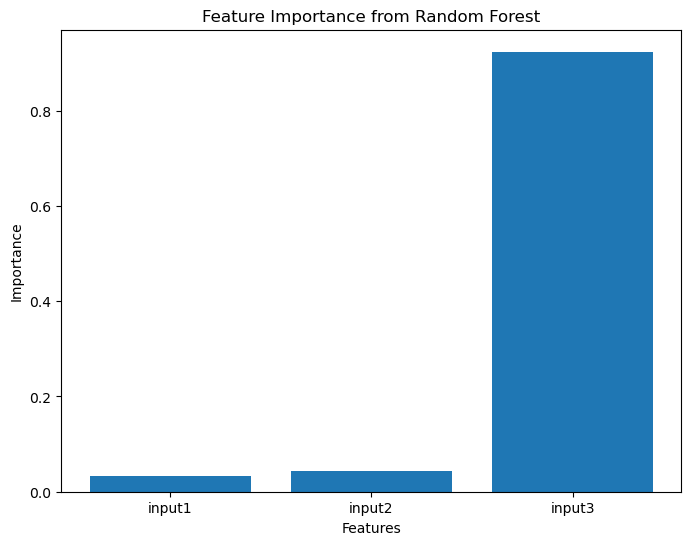


Best Inputs in Provided Data (Closest to Zero):
input1: 0.144466, input2: 0.500000, input3: 0.365304
Output: -0.025076

Fixing least important feature: input1 = 0.5

Best Inputs After Optimization (Predicted by Surrogate Model):
input1: 0.500000, input2: 0.607594, input3: 0.746110
Predicted Output: -0.000000

Best Next Point to Query the Black-Box Function:
input1: 0.500000, input2: 0.944572, input3: 0.437419
Expected Output (Predicted by Surrogate Model): -0.000000


C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


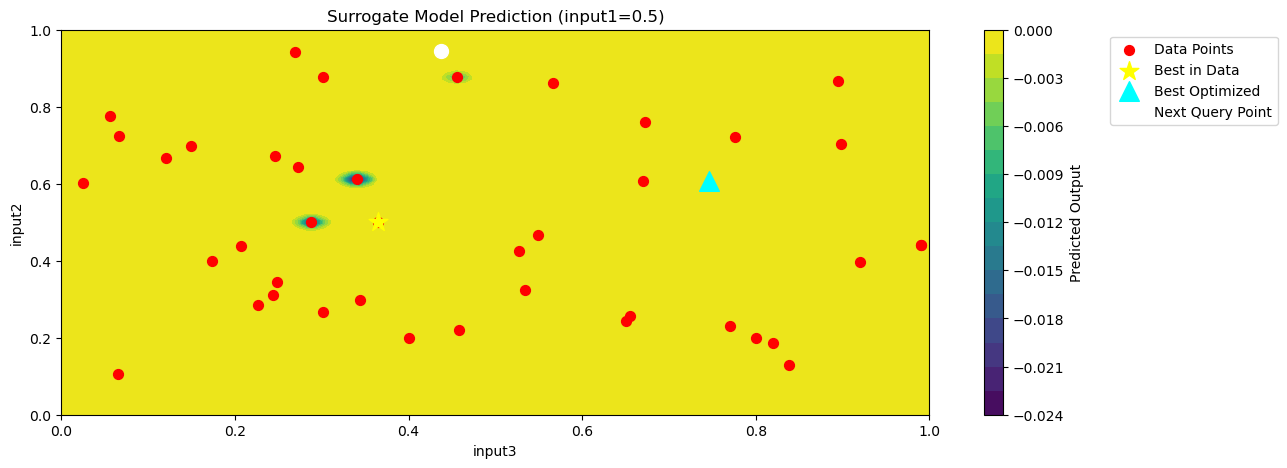

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns

#####################
# this piece of code was provided by a team mate to help automatically extract the queries and observation and remove any duplicates
function = 3
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

###############################

# Create a DataFrame from the inputs with specified column names
df_inputs = pd.DataFrame(X_unique, columns=['input1', 'input2','input3'])

# Create a DataFrame for the outputs
df_outputs = pd.DataFrame(y_unique, columns=['output'])

# Concatenate the inputs and outputs DataFrames
data = pd.concat([df_inputs, df_outputs], axis=1)

# Display the resulting DataFrame
print(data)

##################################

from scipy.optimize import minimize

# Step 1: Feature Importance Analysis
def feature_importance_analysis(data):
    """
    Analyze feature importance using Random Forest.
    Args:
        data (pd.DataFrame): DataFrame with columns ['input1', 'input2', 'input3', 'output']
    Returns:
        dict: Feature importance, e.g., {'input1': score1, 'input2': score2, 'input3': score3}
    """
    X = data[['input1', 'input2', 'input3']]
    y = data['output']
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y.ravel())

    # Get feature importances
    importances = rf.feature_importances_
    feature_names = ['input1', 'input2', 'input3']
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("Feature Importance Analysis:")
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, importances)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance from Random Forest')
    plt.show()
    
    return dict(zip(['input1', 'input2', 'input3'], rf.feature_importances_))

# Step 2: Find the Best Input in Provided Data (Closest to Zero)
def find_best_inputs_data(data):
    """
    Find the input points with the output closest to zero.
    Args:
        data (pd.DataFrame): DataFrame with columns ['input1', 'input2', 'input3', 'output']
    Returns:
        pd.Series: Best input data point
        float: Best output value
    """
    best_idx = data['output'].abs().idxmin()  # Minimize |output|
    best_inputs = data.iloc[best_idx][['input1', 'input2', 'input3']]
    best_output = data['output'].iloc[best_idx]
    
    print("\nBest Inputs in Provided Data (Closest to Zero):")
    print(f"input1: {best_inputs['input1']:.6f}, input2: {best_inputs['input2']:.6f}, input3: {best_inputs['input3']:.6f}")
    print(f"Output: {best_output:.6f}")
    
    return best_inputs, best_output

# Step 3: Bayesian Optimization
def expected_improvement(X, gp, best_y, xi=0.01):
    """
    Compute Expected Improvement for Bayesian optimization.
    Args:
        X (np.ndarray): Candidate points
        gp (GaussianProcessRegressor): Fitted GP model
        best_y (float): Best observed output (minimum for minimization)
        xi (float): Exploration-exploitation trade-off
    Returns:
        np.ndarray: EI values
    """
    X = np.atleast_2d(X)
    mu, sigma = gp.predict(X, return_std=True)
    mu = mu.ravel()
    sigma = sigma.ravel()
    ei = np.zeros_like(mu)
    with np.errstate(divide='warn'):
        imp = best_y - mu - xi
        mask = sigma > 0
        Z = np.zeros_like(mu)
        Z[mask] = imp[mask] / sigma[mask]
        ei[mask] = imp[mask] * norm.cdf(Z[mask]) + sigma[mask] * norm.pdf(Z[mask])
    return ei

def find_best_and_next_points(X_opt, y_opt, feature_names, least_important_feature):
    """
    Perform Bayesian optimization with the least important feature fixed at 0.5.
    Args:
        X_opt (np.ndarray): Input features (all 3 features)
        y_opt (np.ndarray): Output values
        feature_names (list): Names of all features ['input1', 'input2', 'input3']
        least_important_feature (str): Feature to fix at 0.5
    Returns:
        np.ndarray: Best optimized point
        float: Best optimized output
        np.ndarray: Next query point
        float: Expected output at next query point
        GaussianProcessRegressor: Fitted GP model
    """
    # Refit Gaussian Process model on all features
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_opt, y_opt)
    
    # Index of the least important feature
    feature_idx = feature_names.index(least_important_feature)
    
    # Find best point after optimization (minimize predicted output)
    def objective(X):
        # Create full input array with least important feature set to 0.5
        X_full = np.array(X)
        X_full = np.insert(X_full, feature_idx, 0.5)
        return gp.predict(X_full.reshape(1, -1))[0]
    
    # Bounds for the two most important features
    bounds = [(0, 1)] * 2
    res = minimize(objective, x0=np.random.uniform(0, 1, 2), bounds=bounds, method='L-BFGS-B')
    best_point_opt_2d = res.x
    # Reconstruct full 3D point with least important feature set to 0.5
    best_point_opt = np.insert(best_point_opt_2d, feature_idx, 0.5)
    best_output_opt = gp.predict(best_point_opt.reshape(1, -1))[0]
    
    print("\nBest Inputs After Optimization (Predicted by Surrogate Model):")
    print(f"{feature_names[0]}: {best_point_opt[0]:.6f}, {feature_names[1]}: {best_point_opt[1]:.6f}, {feature_names[2]}: {best_point_opt[2]:.6f}")
    print(f"Predicted Output: {best_output_opt:.6f}")
    
    # Find next query point (maximize EI)
    def ei_objective(X):
        X_full = np.array(X)
        X_full = np.insert(X_full, feature_idx, 0.5)
        return -expected_improvement(X_full.reshape(1, -1), gp, best_y=np.min(y_opt))
    
    res = minimize(ei_objective, x0=np.random.uniform(0, 1, 2), bounds=bounds, method='L-BFGS-B')
    next_point_2d = res.x
    next_point = np.insert(next_point_2d, feature_idx, 0.5)
    expected_output = gp.predict(next_point.reshape(1, -1))[0]
    
    print("\nBest Next Point to Query the Black-Box Function:")
    print(f"{feature_names[0]}: {next_point[0]:.6f}, {feature_names[1]}: {next_point[1]:.6f}, {feature_names[2]}: {next_point[2]:.6f}")
    print(f"Expected Output (Predicted by Surrogate Model): {expected_output:.6f}")
    
    return best_point_opt, best_output_opt, next_point, expected_output, gp

# Step 4: Plotting with Contour Plots
def plot_results(X_opt, best_inputs_data, best_point_opt, next_point, gp, feature_names, least_important_feature, feature_importances):
    """
    Plot the optimization results using the two most important features, with the least important feature fixed at 0.5.
    Args:
        X_opt (np.ndarray): Input data with all features
        best_inputs_data (pd.Series): Best inputs from original data (all features)
        best_point_opt (np.ndarray): Best optimized point (all features)
        next_point (np.ndarray): Next query point (all features)
        gp (GaussianProcessRegressor): Fitted GP model
        feature_names (list): Names of all features ['input1', 'input2', 'input3']
        least_important_feature (str): Feature fixed at 0.5
        feature_importances (dict): Precomputed feature importances
    """
    # Identify the two most important features
    sorted_features = sorted(feature_importances, key=feature_importances.get, reverse=True)
    most_important_features = [f for f in sorted_features if f != least_important_feature]
    
    # Indices of the features for plotting
    idx1 = feature_names.index(most_important_features[0])
    idx2 = feature_names.index(most_important_features[1])
    fixed_idx = feature_names.index(least_important_feature)
    
    # Create grid for the two most important features
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X_grid_2d = np.vstack([X1.ravel(), X2.ravel()]).T
    
    # Create full 3D grid with least important feature set to 0.5
    X_grid = np.zeros((X_grid_2d.shape[0], 3))
    X_grid[:, idx1] = X_grid_2d[:, 0]
    X_grid[:, idx2] = X_grid_2d[:, 1]
    X_grid[:, fixed_idx] = 0.5
    
    # Predict surrogate model output and EI
    global y_opt  # Access global y_opt
    y_pred, y_std = gp.predict(X_grid, return_std=True)
    ei = expected_improvement(X_grid, gp, np.min(y_opt))
    
    # Reshape for plotting
    y_pred = y_pred.reshape(X1.shape)
    ei = ei.reshape(X1.shape)
    
    # Plot with contour plots
    plt.figure(figsize=(14, 5))
    
    # Surrogate Model Prediction

    contour = plt.contourf(X1, X2, y_pred, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Predicted Output')
    plt.scatter(X_opt[:, idx1], X_opt[:, idx2], c='red', label='Data Points', s=50)
    plt.scatter(best_inputs_data[most_important_features[0]], best_inputs_data[most_important_features[1]], c='yellow', marker='*', s=200, label='Best in Data')
    plt.scatter(best_point_opt[idx1], best_point_opt[idx2], c='cyan', marker='^', s=200, label='Best Optimized')
    plt.scatter(next_point[idx1], next_point[idx2], c='white', marker='o', s=100, label='Next Query Point')
    plt.xlabel(most_important_features[0])
    plt.ylabel(most_important_features[1])
    plt.title(f'Surrogate Model Prediction ({least_important_feature}=0.5)')
    plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
    
   
    plt.show()

# Execute the pipeline
# Step 1: Feature importance
feature_importances = feature_importance_analysis(data)

# Step 2: Find best inputs in provided data
best_inputs_data, best_output_data = find_best_inputs_data(data)

# Step 3: Bayesian optimization with least important feature set to 0.5
feature_names = ['input1', 'input2', 'input3']
least_important_feature = min(feature_importances, key=feature_importances.get)
print(f"\nFixing least important feature: {least_important_feature} = 0.5")
X_opt = data[feature_names].values
global y_opt  # Needed for expected_improvement in plot_results
y_opt = data['output'].values
best_point_opt, best_output_opt, next_point, expected_output, gp = find_best_and_next_points(X_opt, y_opt, feature_names, least_important_feature)

# Step 4: Plot results
plot_results(X_opt, best_inputs_data, best_point_opt, next_point, gp, feature_names, least_important_feature, feature_importances)

##########################